In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Inversion

### Example with Exponential distribution

In [2]:
# beta = 1 / lambda
beta = 0.1
size = 10000

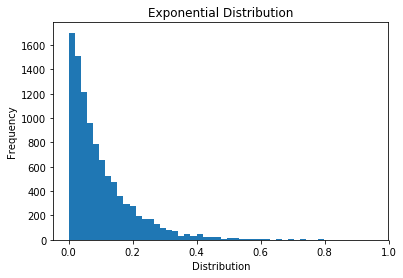

In [3]:
X = np.random.exponential(beta, size=size)

plt.title("Exponential Distribution")
plt.ylabel("Frequency")
plt.xlabel("Distribution")
plt.hist(X, bins=50);

Inversion of the Cumulative Distribution Function :

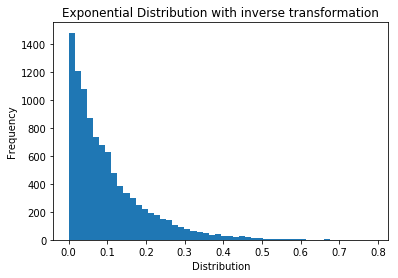

In [4]:
Y = - beta * np.log(np.random.uniform(size=size))

plt.title("Exponential Distribution with inverse transformation")
plt.ylabel("Frequency")
plt.xlabel("Distribution")
plt.hist(Y, bins=50);

## Rejection

### Introduction to Rejection

If you can simple a uniform distribution on [0,1] and you want to sample on a smaller interval, you can "select" the number you generated.

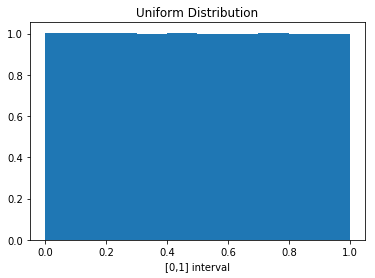

In [19]:
U = np.random.uniform(size=10**6)

plt.title("Uniform Distribution")
plt.xlabel("[0,1] interval")
plt.hist(U,density=True);

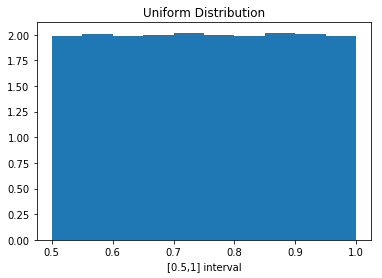

In [23]:
V = U[U>0.5]

plt.title("Uniform Distribution")
plt.xlabel("[0.5,1] interval")
plt.hist(V,density=True);

Suppose we have some observations from the density we want to generate (here, $f$ function) and we know how to sample with a $g$ function.

**Note :** The probability distribution function shows how the sample should look like. It doesn't give a way to generate such a sample.

In [31]:
def f(x):
    """
    Compute normal density
    """
    return 1/np.sqrt(2*np.pi) * np.exp(-1/2*x**2)

def g(x):
    """
    Computer Cauchy distribution density
    """
    return 1/(np.pi*(1+x**2))

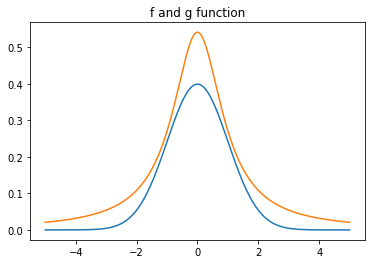

In [41]:
interval = np.linspace(-5,5,1000)

fx = f(interval)
gx = M*g(interval)

plt.title("f and g function")
plt.plot(interval,fx)
plt.plot(interval,gx)

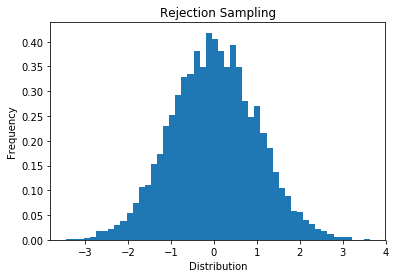

In [34]:
M = 1.7
Y = np.random.standard_cauchy(size=size)
U = np.random.uniform(size=size)

generated_sample = Y[ U<=f(Y)/(M*g(Y)) ]

plt.title("Rejection Sampling")
plt.ylabel("Frequency")
plt.xlabel("Distribution")
plt.hist(generated_sample, density=True, bins=50);

## Chain Rule

## Ziggurat algorithm

In [38]:
def f(x):
    """
    Compute normal density
    """
    return 1/np.sqrt(2*np.pi) * np.exp(-1/2*x**2)

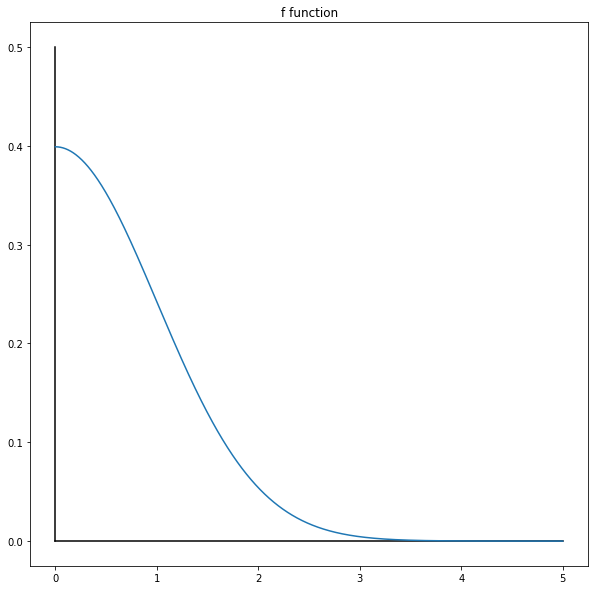

In [49]:
interval = np.linspace(0,5,1000)

fx = f(interval)

plt.figure(figsize=(10,10))
plt.title("f function")
plt.plot([0,5],[0,0], color="black")
plt.plot([0,0],[0,0.5], color="black")

plt.plot(interval,fx)

# Specialized generation method

### Box-Muller

In [11]:
U = np.random.uniform(size=10**6)
V = np.random.uniform(size=10**6)

X = np.sqrt(-2*np.log(U))*np.cos(2*np.pi*V)
Y = np.sqrt(-2*np.log(U))*np.sin(2*np.pi*V)

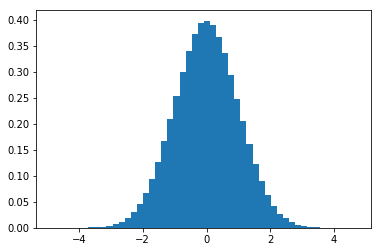

In [13]:
plt.hist(X, density=True, bins=50);

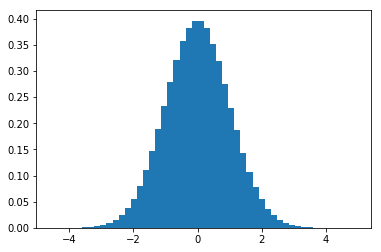

In [14]:
plt.hist(Y, density=True, bins=50);

### Box-Muller with rejection

In [26]:
U = np.random.uniform(-1,1,size=10**6)
V = np.random.uniform(-1,1,size=10**6)

S = U**2 + V**2

#Keep only S <= 1
idx = S<=1
S = S[idx]

K = np.sqrt(-2*np.log(S)/S)

X = U[idx]*K
Y = V[idx]*K

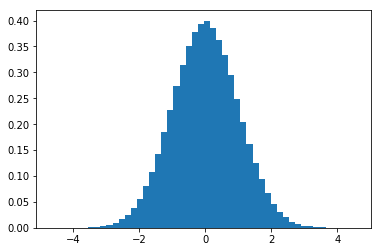

In [28]:
plt.hist(X, density=True, bins=50);

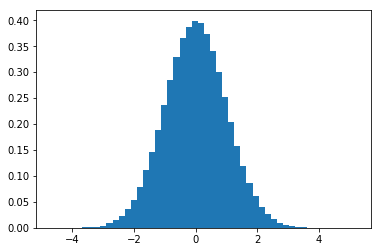

In [29]:
plt.hist(Y, density=True, bins=50);